In [20]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.higher_order_hmm_graphical_lasso import HHMM_GraphicalLasso
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap
from regain.hmm.utils import cross_validation_higher_order,spread_pred_interpretation
import pickle as pkl
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from regain.hmm.utils import corr_plot,plot_results_cluster,cov2corr,cluster_returns_recap

In [41]:
N_samples = 1000
N_states = 2
Mem = 3
N_TS = 5
sigma_Normal = 1

dataset = generate_hmm(n_samples= N_samples,
                       n_states=N_states,
                       n_dim_obs=N_TS,
                       mode_precisions='regain_random',
                       mode_mean = 'Normal',
                       transition_type='fixed',
                       sigma=sigma_Normal,
                       order_hmm = Mem)

[2002.41599069 2047.62024516 2071.58936467 2020.72047489 2070.49215501]


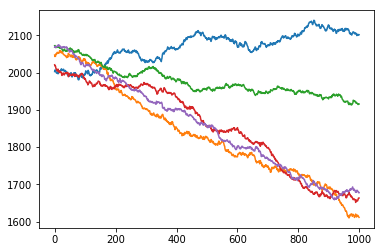

In [42]:
p_vec_0 = np.random.uniform(0,100,N_TS)+2000
Data = np.zeros((np.size(dataset['data'],axis=0),N_TS))
print(p_vec_0)
for j in range(N_TS):
    #print(p_vec_0[j])
    #print(np.cumsum(dataset['data'][:,j]))
    plt.plot(p_vec_0[j]+np.cumsum(dataset['data'][:,j]))
    Data[:,j] = p_vec_0[j]+np.cumsum(dataset['data'][:,j])
    
plt.show()

In [43]:
lam = 8.37
max_iter = 1000

mdl = HHMM_GraphicalLasso(alpha=lam,
                         n_clusters=N_states,
                         verbose=False,
                         max_iter=max_iter,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=50,
                         n_jobs=-1,
                         N_memory_trans = Mem,
                         N_memory_emis=1,)
mdl.fit(dataset['data'])

HHMM_GraphicalLasso(N_memory_emis=1, N_memory_trans=3, alpha=8.37,
                    init_params={}, max_iter=1000, mode='scaled', n_clusters=2,
                    n_jobs=-1, repetitions=50, tol=0.0001, verbose=False,
                    warm_restart=True)

In [38]:
np.unique(mdl.lambdas)

array([0.01097614, 0.03023336, 0.03525144, 0.06046671, 0.08453366,
       0.08453366, 0.09968712, 0.55610526])

In [11]:
mdl.precisions_[4]

array([[ 0.91404627, -0.01531943,  0.        , -0.00497632,  0.81009511],
       [-0.01531943,  0.98073542, -0.05808433, -0.        ,  0.        ],
       [ 0.        , -0.05808433,  1.06058724,  0.0611272 , -0.03406597],
       [-0.00497632, -0.        ,  0.0611272 ,  0.87434035, -0.02373597],
       [ 0.81009511,  0.        , -0.03406597, -0.02373597,  0.90899677]])

In [47]:
dataset['thetas'][7]

array([[1. , 0.9],
       [0.9, 1. ]])

In [36]:
results_recap(dataset['states'], mdl.labels_, dataset['thetas'], mdl.precisions_, 
              dataset['gammas'], mdl.gammas_) 

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


ValueError: operands could not be broadcast together with shapes (8,8) (8,7) 

In [28]:
res = cross_validation_higher_order(mdl,
       dataset['data'],
       params={'alpha':np.linspace(1,15 ,20),
               'n_clusters':[N_states],
               'N_memory_trans': [Mem]},
       n_repetitions=5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [25:29<00:00, 1529.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [44:32<00:00, 2672.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [47:36<00:00, 2856.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [41:37<00:00, 2497.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [45:47<00:00, 2747.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [21:44<00:00, 1304.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [22:34<00:00, 1354.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [46:38<00:00

In [33]:
res[0]

(8.368421052631579, 2, 3)

In [34]:
np.unique(mdl.labels_[1:])

array([0, 1, 2, 3, 4, 6, 7])

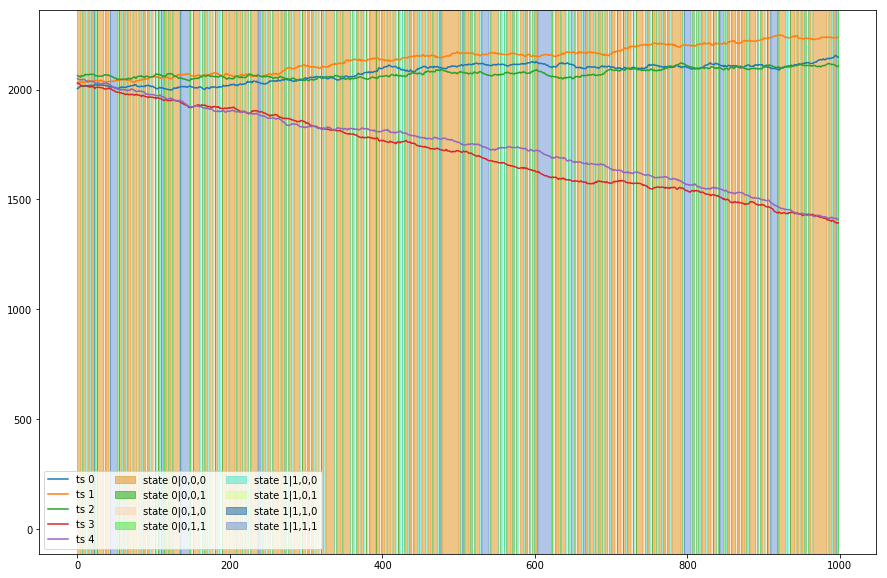

In [37]:
plot_results_cluster(Data, mdl.labels_[1:],N_st = N_states,mem = Mem,HHMM = True)

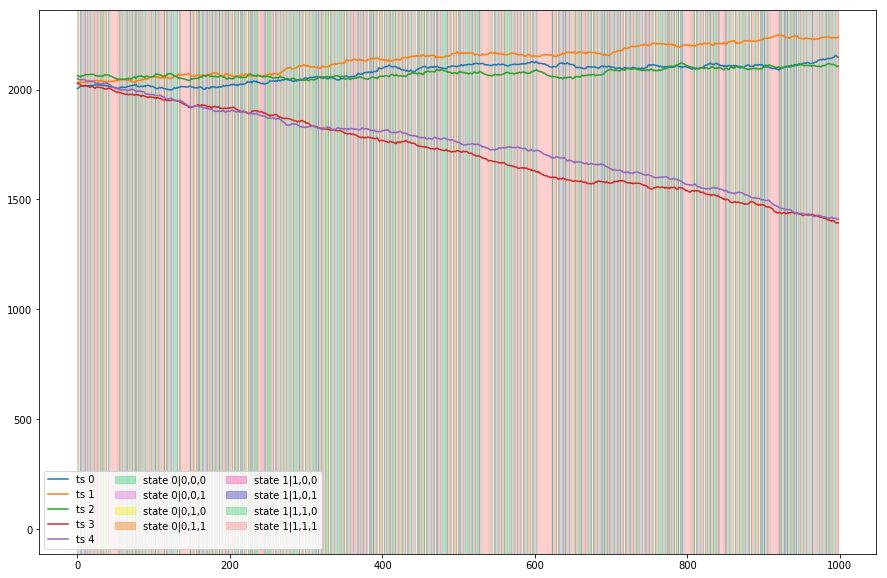

In [32]:
plot_results_cluster(Data, dataset['states'][1:],N_st = N_states,mem = Mem,HHMM = True)